In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [3]:
fpath = '/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
df = pd.read_csv(fpath)
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Visualize Data

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

(12, 12) (12, 12)


<Axes: >

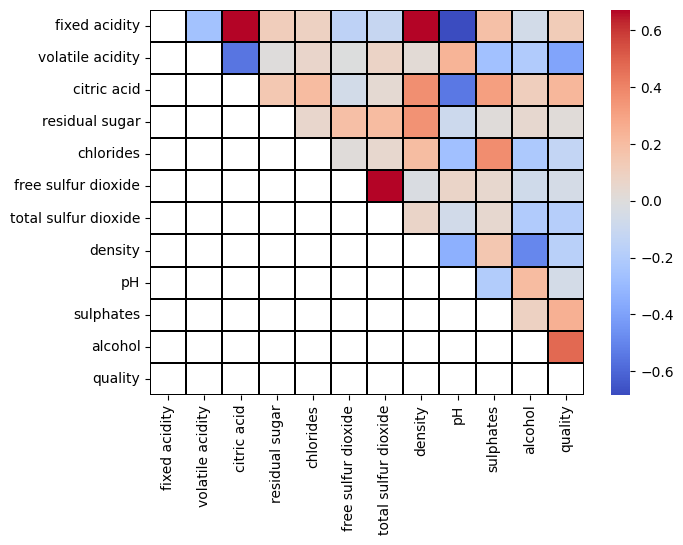

In [7]:
corr_mat = df.corr()
mask = np.tril(np.ones_like(corr_mat))
print(corr_mat.shape,mask.shape)
plt.figure(figsize=(7,5))
sns.heatmap(data=corr_mat,mask=mask,cmap='coolwarm',annot=False,fmt='.2f',linewidths=0.25,linecolor='k')


Alcohol, sulphates, citric acid, and fixed acidity seem to have a linear relationship with quality.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

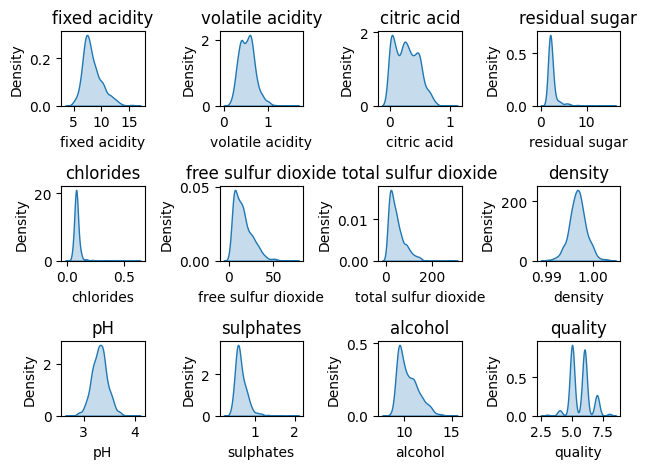

In [10]:
num_cols = math.ceil(math.sqrt(len(df.columns)))
num_rows = math.ceil(len(df.columns)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols)

for ax, feat in zip(axs.flatten(),df.columns):
    sns.kdeplot(data=df,x=feat,ax=ax, fill=True)
    ax.set_title(feat)

plt.tight_layout()

In the correlation matrix above I see that alcohol, fixed acidity, and citric acid may have a linear relationship with quality. But I am noticing that pH has a very Gaussian-like distribution, but alcohol and citric acid do not. Both alcohol and citric acid content would affect the pH. In fact, there might be quite a bit of data leakage going on between alcohol, volatile acidity, fixed acidity, residual sugar, and citric acid. I also think that chlorides, sulphates, and sulfur dioxide may play a secondary role in pH.

My gut feeling says that I could probably drop the pH feature, but I will have to look into that more deeply.

**Similar Distributions:**
a. free sulfur dioxide, total sulfur dioxide, residual sugar, alcohol (maybe), chlorides (maybe)
b. fixed acidity, volatile acidity
c. density, pH


### Actionable Insights:
1. Check for data leakage in pH and other features (fixed acidity).
2. Use spectral analysis to see if similar distributions are actually similar.

/tmp/ipykernel_35/314675611.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('quality_binned')['quality'].sum().plot(kind='bar')


Text(0.5, 1.0, 'Wine Quality Binned')

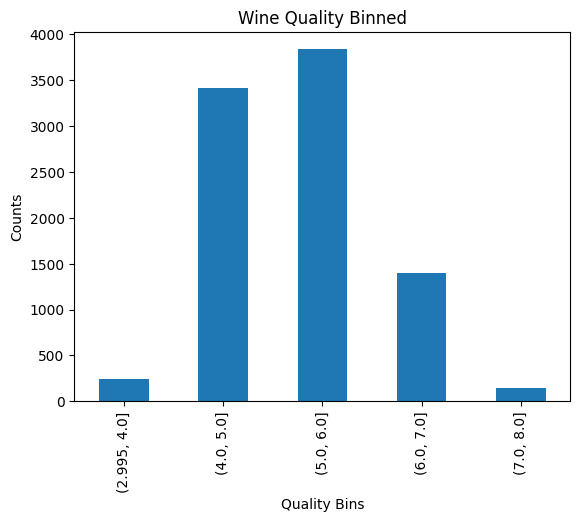

In [34]:
df['quality_binned'] = pd.cut(df['quality'],bins=5)
plt.figure()
df.groupby('quality_binned')['quality'].sum().plot(kind='bar')
plt.xlabel('Quality Bins')
plt.ylabel('Counts')
plt.title('Wine Quality Binned')

## Check for data leakage in features.

In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

from scipy.fft import fft, ifft

from numpy.linalg import norm

from itertools import combinations

fpath = '/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
df = pd.read_csv(fpath)

In [15]:
def rf_feature_checker(X,y,
                       n_estimators=100,
                       min_samples_split=2,
                       min_samples_leaf=1,
                       test_size=0.2,
                      ):

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,)
    rfr_model = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    rfr_model.fit(X_train,y_train)
    preds = rfr_model.predict(X_test)
    r2 = r2_score(y_test,preds)
    print(f"R2-Score: {r2:.4f}")

R2-Score: 0.76
R2-Score: 0.73


# Notes on Dataset Features

1. Fixed Acidity - Acids that will stay in solution (e.g., malic, tartaric, citric, and succinic). Affects the color, pH, sourness, taste, and shelf-life. **Affects pH** (https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity , https://winemakersacademy.com/understanding-wine-acidity/)
2. Volatile Acidity - Volatile acids such as acetic acid (vinegar) and ethyl acetate. These cause vinegary or nail polish like smells. Probably higher VA, lower quality. **Affects pH** (https://www.wineenthusiast.com/basics/drinks-terms-defined/volatile-acidity-wine/)
3. Citric Acid - Is metabolized into diacetyl which can have an offputting smell but can also cause buttery or butterscotch flavor which might be desirable. Might be a sweet spot where wines in that range are higher in quality if at a certain diacetyl level, which would be a lower citric acid level. **Affects pH** (https://wineserver.ucdavis.edu/industry-info/enology/methods-and-techniques/common-chemical-reagents/citric-acid)
4. Residual Sugar - Amount of sugar left over after fermentation process is complete. Higher in sweeter wines, lower in dryer wines. (https://winefolly.com/deep-dive/what-is-residual-sugar-in-wine/)
5. Chloride - Might affect perceived sweetness in wine probably by interacting with the tastebuds or by pulling acidic hydrogens away from the organic acids (citric acid especially). **It might be worth doing a simple dissociation constant analysis on this feature** (https://daily.sevenfifty.com/the-science-of-salinity-in-wine/ , https://pmc.ncbi.nlm.nih.gov/articles/PMC9977269/)
6. Free Sulfur Dioxide - Sulfur Dioxide in hibits microbe growth by removing oxygen. When it is oxidized into SO3 (2-) and SO4 (2-) it will effect the pH. Less probably means there is less oxygen to start with. I am not sure how that would correlate to a quality rating if at all. **Affects pH** (https://extension.okstate.edu/fact-sheets/understanding-free-sulfur-dioxide-fso2-in-wine.html)
7. Total Sulfur Dioxide - Likely the amount of $SO_n$ molecules.
8. Density - Mass per unit Volume. Related to how long your taste buds can interact with the wine. If it's high density AND unpleasant then it might get a lower quality rating. (https://winedharma.com/en/wine-school/unlocking-the-secrets-of-wine-density-and-concentration/)
9. pH - -log([H+])
10. Sulphates - I can't find anything about sulphates, but sulfites seem to be a pretty popular topic in wine making. From the discussion page on this dataset:  "This measures the concentration of sulfate salts, primarily potassium sulfate, in the wine. Sulfates are naturally present in grapes and can also be added during winemaking processes. Excessive sulfate levels may contribute to a bitter or metallic taste in the wine." (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/discussion/456651)
11. Alcohol - It's the alcohol content.

In [112]:
def distribution_spectrum_similarity(
    data,feat1,feat2,
    num_bins=512, n=50, 
    return_metrics=False,
    print_metrics=False,
):
    #Get max and min values for value ranges
    ranges = (min(data[feat1].min(),data[feat2].min()),max(data[feat1].max(),data[feat2].max()))

    #Get binned data
    hist1, _ = np.histogram(data[feat1],bins=num_bins,range=ranges,density=True)
    hist2, _ = np.histogram(data[feat2],bins=num_bins,range=ranges,density=True)

    #Fast Fourier Transform to get spectrum
    fft1 = np.abs(fft(hist1))
    fft2 = np.abs(fft(hist2))

    #Extract most prominent frequencies
    v1 = fft1[1:n]
    v2 = fft2[1:n]

    #Check similarities in feature spectra
    cos_similar = cosine_similarity([v1],[v2])[0][0]
    euclidian_distance = norm(v1-v2)

    if print_metrics == True:
        print(f"{feat1} & {feat2}")
        print(f"Cosine Similarity: {cos_similar:.4f}")
        print(f"Euclidian Distance: {euclidian_distance:.4f}")
        print('')
    if return_metrics == True:
        return cos_similar, euclidian_distance

#Check similarities of all feature spectra
similar_feats = df.columns
leaky_feats = []
for feat1,feat2 in list(combinations(similar_feats,2)):
    cos, euc = distribution_spectrum_similarity(
        data=df,
        feat1=feat1,
        feat2=feat2,
        return_metrics=True,
    )

    if cos > 0.90:
        leaky_feats.append((feat1,feat2))

suspected_leak_feats = [
    'fixed acidity','volatile acidity','citric acid','chlorides','free sulfur dioxide',
    'total sulfur dioxide','sulphates','alcohol',
]

X_ = df[suspected_leak_feats]
rf_feature_checker(X=df[suspected_leak_feats],y=df['pH'],n_estimators=250)
y_ = X_.pop('fixed acidity')
rf_feature_checker(X=X_,y=y_)

#Get unique features and initialize array
unique_leaky_feats = list(set([feat for feats in leaky_feats for feat in feats]))
num_unique_feats = len(unique_leaky_feats)
leaky_arr = np.zeros((num_unique_feats,num_unique_feats))

#For highly similar spectra put a 1 in the array, else 0
for f1,f2 in leaky_feats:
    leaky_arr[unique_leaky_feats.index(f1),unique_leaky_feats.index(f2)] = 1
    leaky_arr[unique_leaky_feats.index(f2),unique_leaky_feats.index(f1)] = 1

print(unique_leaky_feats)
print(leaky_arr)

['feature_7', 'feature_3', 'feature_2', 'feature_4', 'chlorides', 'pH', 'density', 'fixed acidity', 'feature_0', 'alcohol', 'feature_1', 'feature_6', 'quality', 'feature_5', 'citric acid', 'residual sugar', 'total sulfur dioxide', 'sulphates', 'volatile acidity', 'feature_8', 'free sulfur dioxide']
[[0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.

# Feature Engineering

In [117]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

from scipy.fft import fft, ifft

from numpy.linalg import norm

from itertools import combinations

fpath = '/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
df = pd.read_csv(fpath)

In [114]:
def distribution_spectrum_similarity(
    data,feat1,feat2,
    num_bins=512, n=50, 
    return_metrics=False,
    print_metrics=False,
):
    #Get max and min values for value ranges
    ranges = (min(data[feat1].min(),data[feat2].min()),max(data[feat1].max(),data[feat2].max()))

    #Get binned data
    hist1, _ = np.histogram(data[feat1],bins=num_bins,range=ranges,density=True)
    hist2, _ = np.histogram(data[feat2],bins=num_bins,range=ranges,density=True)

    #Fast Fourier Transform to get spectrum
    fft1 = np.abs(fft(hist1))
    fft2 = np.abs(fft(hist2))

    #Extract most prominent frequencies
    v1 = fft1[1:n]
    v2 = fft2[1:n]

    #Check similarities in feature spectra
    cos_similar = cosine_similarity([v1],[v2])[0][0]
    euclidian_distance = norm(v1-v2)

    if print_metrics == True:
        print(f"{feat1} & {feat2}")
        print(f"Cosine Similarity: {cos_similar:.4f}")
        print(f"Euclidian Distance: {euclidian_distance:.4f}")
        print('')
    if return_metrics == True:
        return cos_similar, euclidian_distance

#Check similarities of all feature spectra
similar_feats = df.columns
leaky_feats = []
for feat1,feat2 in list(combinations(similar_feats,2)):
    cos, euc = distribution_spectrum_similarity(
        data=df,
        feat1=feat1,
        feat2=feat2,
        return_metrics=True,
    )

    if cos > 0.90:
        leaky_feats.append((feat1,feat2))

#Get unique features and initialize array
unique_leaky_feats = list(set([feat for feats in leaky_feats for feat in feats]))
num_unique_feats = len(unique_leaky_feats)
leaky_arr = np.zeros((num_unique_feats,num_unique_feats))

#For highly similar spectra put a 1 in the array, else 0
for f1,f2 in leaky_feats:
    leaky_arr[unique_leaky_feats.index(f1),unique_leaky_feats.index(f2)] = 1
    leaky_arr[unique_leaky_feats.index(f2),unique_leaky_feats.index(f1)] = 1

print(unique_leaky_feats)
print(leaky_arr)

['total sulfur dioxide', 'fixed acidity', 'sulphates', 'volatile acidity', 'alcohol', 'citric acid', 'pH', 'free sulfur dioxide', 'residual sugar']
[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]]


## Use Linearly Independent Feature Space to Transform Features

In [ ]:
#Find eigenvectors
eigvals, P = np.linalg.eig(leaky_arr)
P_inv = np.linalg.inv(P)

#Check diagonalizability and get diagonal matrix
try:
    D = np.diag(leaky_arr)
except:
    print("Array way not diagonalizable")
    raise

#Use linear algebra to find the linear independent feature spectra
leaky_data = df[unique_leaky_feats].to_numpy()
M = np.abs(fft(leaky_data, axis=1))
independent_feat_spectra = M @ P_inv

#Inverse fft to get independent features
independent_feats = ifft(independent_feat_spectra,axis=0)
independent_feats_real = np.abs(independent_feats)

#Append independent features to dataset
independent_feat_names = ['feature_'+str(i) for i in range(independent_feats_real.shape[1])]
for i,feat in enumerate(independent_feat_names):
    df[feat] = independent_feats_real[:,i]

df.columns

## Test with RandomForestRegressor

Here is a list of the unique features that have a high cosine similarity score:
1. fixded acidity
2. alcohol
3. volatile acidity
4. pH
5. sulphates
6. citric acid
7. residual sugar
8. free sulfur dioxide
9. total sulfur dioxide

If I make a matrix where the overlapping entries have a cosine similarity score greater than 0.90, I get a table that looks like this:
$$
\begin{matrix}
- & fixed\,acidity & alcohol & volatile\,acidity & pH & sulphates & citric\,acid & residual\,sugar & free\,sulfur\,dioxide & total\,sulfur\,dioxide\\
fixed\,acidity & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
alcohol & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
volatile\,acidity & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0\\
pH & 0 & 0 & 1 & 0 & 1 & 1 & 0 & 0 & 0\\
sulphates & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0\\
citric\,acid & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0\\
residual\,sugar & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
free\,sulfur\,dioxide & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
total\,sulfur\,dioxide & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
\end{matrix}
$$



This matrix is diagonalizable which means we can use the spectrum of each feature distribution to engineer a new set of features.

### Actionable Insight:
Engineer new features from leaky features.
1. Get spectrum of each feature distribution.
2. Find cosine similarities > 0.90
3. Make array of leaky features.
4. Diagonalize and find eigenvectors of array
5. Use eigenvectors to transform leaky feature spectra.
6. Perform inverse fourier transform on spectra to create a new set of features. These should be linearly independent.

In [131]:
X = df[[feat for feat in list(df.columns) if feat not in unique_leaky_feats]].copy()
y = X.pop('quality')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_ = df[[feat for feat in list(df.columns) if feat not in independent_feat_names]].copy()
y_ = X_.pop('quality')

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2)
test_model = RandomForestRegressor(n_estimators=200)
test_model.fit(X_train, y_train)
test_preds = test_model.predict(X_test)
print(f"MAE for engineered features: {mean_absolute_error(y_test, test_preds)*100:.2f}%")

test_model_2 = RandomForestRegressor(n_estimators=200)
test_model_2.fit(X_train_,y_train_)
test_preds_ = test_model_2.predict(X_test_)
print(f"MAE for non-engineered features: {mean_absolute_error(y_test_,test_preds_)*100:.2f}%")

X__ = df.copy()
y__ = X__.pop('quality')
X_train__, X_test__, y_train__, y_test__ = train_test_split(X__,y__,test_size=0.2)
test_model_3 = RandomForestRegressor(n_estimators=200)
test_model_3.fit(X_train__, y_train__)
test_preds__ = test_model_3.predict(X_test__)
print(f"MAE for both feat sets: {mean_absolute_error(y_test__, test_preds__)*100:.2f}%")

MAE for engineered features: 62.38%
MAE for non-engineered features: 42.52%
MAE for both feat sets: 40.63%


Random forests don't seem to be working well on this dataset. I will try a couple of gradient boosting algorithms next.

### Actionable Insights:
1. Try with gradient boosting
2. Try with xgboost
3. Try with catboost
4. Try with SVM
5. Try with K-Nearest Neighbors

# Building Models

## Gradient Boosting